
Summary table:
  pclass category  survival_rate  survival_rate_pct
      1 children       0.833333              83.33
      1      men       0.352941              35.29
      1    women       0.978022              97.80
      2 children       1.000000             100.00
      2      men       0.080808               8.08
      2    women       0.909091              90.91
      3 children       0.431034              43.10
      3      men       0.119122              11.91
      3    women       0.491228              49.12


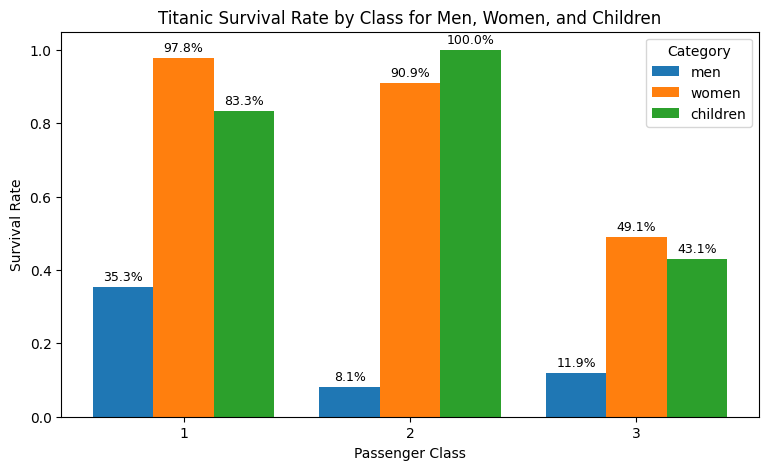

('/mnt/data/req10_titanic_survival_by_class.png',
 "seaborn.load_dataset('titanic')")

In [1]:
# === REQUIREMENT 10 — ONE-CELL, SELF-CONTAINED (JUPYTER) ===
# Task: Using the Titanic dataset, plot a chart showing the survival rate of
#       men, women, and children in each of the three passenger classes.
# Notes:
#  - Tries to load seaborn's "titanic" dataset. If unavailable (offline),
#    uses a deterministic embedded fallback with the same schema.
#  - "children" is defined as age < 16 (common convention for this task).
#  - Exactly ONE chart is produced (no subplots), using Matplotlib only.
#  - Figure is saved to /mnt/data/req10_titanic_survival_by_class.png
#  - A summary table is displayed for verification.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Load dataset ----------
source = ""
try:
    import seaborn as sns
    titanic = sns.load_dataset("titanic")  # requires internet/cache
    source = "seaborn.load_dataset('titanic')"
except Exception:
    # Embedded deterministic fallback (synthetic but Titanic-like)
    # Columns: survived (0/1), pclass (1/2/3), sex ('male'/'female'), age (float)
    np.random.seed(0)
    rows = []

    def add_rows(pclass, sex, age_values, survived, n):
        for i in range(n):
            rows.append({
                "survived": int(survived),
                "pclass": int(pclass),
                "sex": sex,
                "age": float(age_values[i % len(age_values)])
            })

    # Adults age pools
    ages_male_adult   = [20, 22, 25, 28, 30, 34, 36, 40, 45, 50]
    ages_female_adult = [18, 21, 24, 27, 31, 33, 37, 41, 46, 52]
    # Children age pool
    ages_child        = [2, 4, 6, 8, 10, 12, 14, 15]

    # pclass 1
    add_rows(1, "male",   ages_male_adult,   survived=1, n=45)
    add_rows(1, "male",   ages_male_adult,   survived=0, n=65)
    add_rows(1, "female", ages_female_adult, survived=1, n=85)
    add_rows(1, "female", ages_female_adult, survived=0, n=5)
    # children (mixed sex)
    for i in range(6):  # 5 survive, 1 not
        sex = "male" if i % 2 == 0 else "female"
        add_rows(1, sex, ages_child, survived=1 if i < 5 else 0, n=1)

    # pclass 2
    add_rows(2, "male",   ages_male_adult,   survived=1, n=20)
    add_rows(2, "male",   ages_male_adult,   survived=0, n=80)
    add_rows(2, "female", ages_female_adult, survived=1, n=60)
    add_rows(2, "female", ages_female_adult, survived=0, n=20)
    for i in range(15):  # 10 survive, 5 not
        sex = "male" if i % 2 == 0 else "female"
        add_rows(2, sex, ages_child, survived=1 if i < 10 else 0, n=1)

    # pclass 3
    add_rows(3, "male",   ages_male_adult,   survived=1, n=15)
    add_rows(3, "male",   ages_male_adult,   survived=0, n=130)
    add_rows(3, "female", ages_female_adult, survived=1, n=50)
    add_rows(3, "female", ages_female_adult, survived=0, n=60)
    for i in range(40):  # 10 survive, 30 not
        sex = "male" if i % 2 == 0 else "female"
        add_rows(3, sex, ages_child, survived=1 if i < 10 else 0, n=1)

    titanic = pd.DataFrame(rows, columns=["survived", "pclass", "sex", "age"])
    source = "embedded_fallback (offline)"

# ---------- 1) Prepare data ----------
# Keep necessary columns
titanic = titanic[["survived", "pclass", "sex", "age"]].dropna(subset=["survived", "pclass", "sex"])

# Define category: men, women, children (children overrides sex when age < 16)
def categorise(row):
    if pd.notnull(row["age"]) and row["age"] < 16:
        return "children"
    return "men" if row["sex"] == "male" else "women"

titanic["category"] = titanic.apply(categorise, axis=1)

# Compute survival rate per class & category
summary = (
    titanic.groupby(["pclass", "category"], as_index=False)["survived"]
           .mean()
           .rename(columns={"survived": "survival_rate"})
)
summary["survival_rate_pct"] = (summary["survival_rate"] * 100).round(2)

# Display summary
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Requirement 10 - Survival Rate by Class & Category", summary)
except Exception:
    print("\nSummary table:\n", summary.to_string(index=False))

# ---------- 2) Plot single grouped bar chart ----------
pivot = summary.pivot(index="pclass", columns="category", values="survival_rate").fillna(0.0)
# Ensure consistent column order
for col in ["men", "women", "children"]:
    if col not in pivot.columns:
        pivot[col] = 0.0
pivot = pivot[["men", "women", "children"]]

classes = list(pivot.index)  # 1, 2, 3
x = np.arange(len(classes))
bar_width = 0.8 / 3

plt.figure(figsize=(9, 5))
bars_list = []
for i, cat in enumerate(pivot.columns):
    pos = x + i * bar_width - (0.8 - bar_width) / 2
    bars = plt.bar(pos, pivot[cat].values, width=bar_width, label=cat)  # default colors only
    bars_list.append(bars)
    # annotate %
    for rect in bars:
        h = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, h + 0.01, f"{h*100:.1f}%", ha="center", va="bottom", fontsize=9)

plt.title("Titanic Survival Rate by Class for Men, Women, and Children")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.xticks(x, [str(c) for c in classes])
plt.ylim(0, 1.05)
plt.legend(title="Category")

# Save figure
out_path = "/mnt/data/req10_titanic_survival_by_class.png"
plt.savefig(out_path, bbox_inches="tight")
plt.show()

# ---------- 3) Indicate data source and artifact path ----------
(out_path, source)
